In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scrabble-player-rating/sample_submission.csv
/kaggle/input/scrabble-player-rating/games.csv
/kaggle/input/scrabble-player-rating/turns.csv
/kaggle/input/scrabble-player-rating/train.csv
/kaggle/input/scrabble-player-rating/test.csv


In [2]:
#data cleansing
import pandas as pd
import numpy as np
import datetime as dt # library ที่ใช้ในการจัดการวันที่

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [3]:
games = pd.read_csv('/kaggle/input/scrabble-player-rating/games.csv')
test = pd.read_csv('/kaggle/input/scrabble-player-rating/test.csv')
train = pd.read_csv('/kaggle/input/scrabble-player-rating/train.csv')
turns = pd.read_csv('/kaggle/input/scrabble-player-rating/turns.csv')
sample = pd.read_csv('/kaggle/input/scrabble-player-rating/sample_submission.csv')

In [4]:
#ohe function
def ohe_function(df, columns):
  ohe = OneHotEncoder()
  ohe.fit_transform(df[[columns]]).toarray()
  matrix = ohe.fit_transform(df[[columns]]).toarray()
  column_names = ohe.get_feature_names_out()  
  for i in range(len(matrix.T)):
            df[column_names[i]]= matrix.T[i]
  df = df.drop(columns=[columns])
  
#label encoder function
def le_function(df,columns):
  from sklearn import preprocessing
  le = preprocessing.LabelEncoder()
  df[columns] = le.fit_transform(df[columns])

In [5]:
train

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473
...,...,...,...,...
100815,72771,HastyBot,393,1614
100816,72772,BetterBot,442,1674
100817,72772,Gtowngrad,388,1364
100818,72773,adola,383,2075


In [6]:
games

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
...,...,...,...,...,...,...,...,...,...,...,...,...
72768,72769,browndav,blitz,STANDARD,0,2022-09-07 13:24:13,CSW21,180,0,RATED,1,218.043751
72769,72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287
72770,72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634
72771,72772,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,NWL20,900,0,RATED,1,681.370077


In [7]:
turns

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play
...,...,...,...,...,...,...,...,...,...
2005493,72773,22,adola,ABINRRU,15N,IN,18,376,Play
2005494,72773,23,HastyBot,EGHIIP,H12,.HIG,24,331,Play
2005495,72773,24,adola,ABRRU,15E,BRA.,7,383,Play
2005496,72773,25,HastyBot,EIP,7A,PIE,11,342,Play


In [8]:
test

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0
...,...,...,...,...
44721,72762,kyjo55555,367,NaN
44722,72768,HastyBot,524,2356.0
44723,72768,Maximilian,357,NaN
44724,72769,STEEBot,626,2110.0


COLUMNS CLEANSING

In [9]:
bot = ['BetterBot', 'STEEBot', 'HastyBot']

bot_name = []
player_name = []
player_score = []
bot_score = []
player_rating = []
bot_rating = []

for i in range(0, len(train['nickname'])):
    if train['nickname'][i] in bot:
        bot_name.append(train['nickname'][i])
        bot_score.append(train['score'][i])
        bot_rating.append(train['rating'][i])
        player_name.append('')
        player_score.append(0)
        player_rating.append(0)
    else :
        bot_name.append('')
        bot_score.append(0)
        bot_rating.append(0)
        player_name.append(train['nickname'][i])
        player_score.append(train['score'][i])
        player_rating.append(train['rating'][i])
        
train['bot_name'] = bot_name
train['bot_score'] = bot_score
train['bot_rating'] = bot_rating
train['player_name'] = player_name
train['player_score'] = player_score
train['player_rating'] = player_rating

train

,game_id,nickname,score,rating,bot_name,bot_score,bot_rating,player_name,player_score,player_rating
0,1,BetterBot,335,1637,BetterBot,335,1637,,0,0
1,1,stevy,429,1500,,0,0,stevy,429,1500
2,3,davidavid,440,1811,,0,0,davidavid,440,1811
3,3,BetterBot,318,2071,BetterBot,318,2071,,0,0
4,4,Inandoutworker,119,1473,,0,0,Inandoutworker,119,1473
...,...,...,...,...,...,...,...,...,...,...
100815,72771,HastyBot,393,1614,HastyBot,393,1614,,0,0
100816,72772,BetterBot,442,1674,BetterBot,442,1674,,0,0
100817,72772,Gtowngrad,388,1364,,0,0,Gtowngrad,388,1364
100818,72773,adola,383,2075,,0,0,adola,383,2075


In [10]:
df = train.copy()
df = df.drop(['nickname', 'score', 'rating'], axis=1)
le_function(df,'bot_name')
le_function(df,'player_name')
df = df.groupby(['game_id']).sum()
df

,bot_name,bot_score,bot_rating,player_name,player_score,player_rating
game_id,,,,,,
1,1,335,1637,958,429,1500
3,1,318,2071,709,440,1811
4,1,478,1936,225,119,1473
5,3,427,1844,958,325,1500
6,3,427,2143,213,378,2029
...,...,...,...,...,...,...
72767,1,414,1952,191,340,1395
72770,2,590,2237,922,97,1332
72771,2,393,1614,69,390,1500


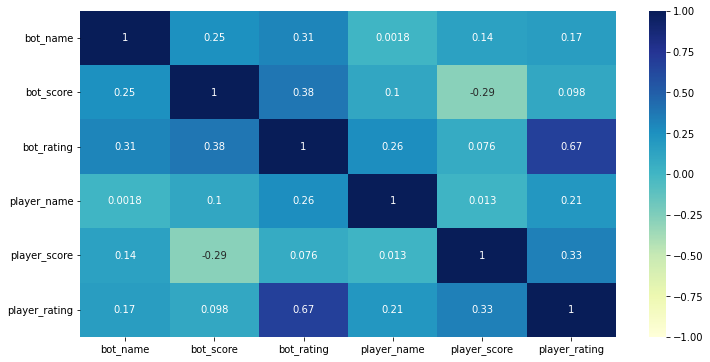

In [11]:
#เช็คค่า corr
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')

In [12]:
games

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
...,...,...,...,...,...,...,...,...,...,...,...,...
72768,72769,browndav,blitz,STANDARD,0,2022-09-07 13:24:13,CSW21,180,0,RATED,1,218.043751
72769,72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287
72770,72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634
72771,72772,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,NWL20,900,0,RATED,1,681.370077


In [13]:
def file_merge(df):
  result = pd.merge(df, games,how="left", on=["game_id"])
  return result

df2 = file_merge(df)
df2

,game_id,bot_name,bot_score,bot_rating,player_name,player_score,player_rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,1,335,1637,958,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,3,1,318,2071,709,440,1811,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
2,4,1,478,1936,225,119,1473,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
3,5,3,427,1844,958,325,1500,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
4,6,3,427,2143,213,378,2029,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,72767,1,414,1952,191,340,1395,BetterBot,regular,TIME,0,2022-09-05 04:35:56,CSW21,3600,0,CASUAL,1,3669.988413
50406,72770,2,590,2237,922,97,1332,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287
50407,72771,2,393,1614,69,390,1500,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634
50408,72772,1,442,1674,189,388,1364,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,NWL20,900,0,RATED,1,681.370077


In [14]:
games.columns

Index(['game_id', 'first', 'time_control_name', 'game_end_reason', 'winner',
       'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds',
       'rating_mode', 'max_overtime_minutes', 'game_duration_seconds'],
      dtype='object')

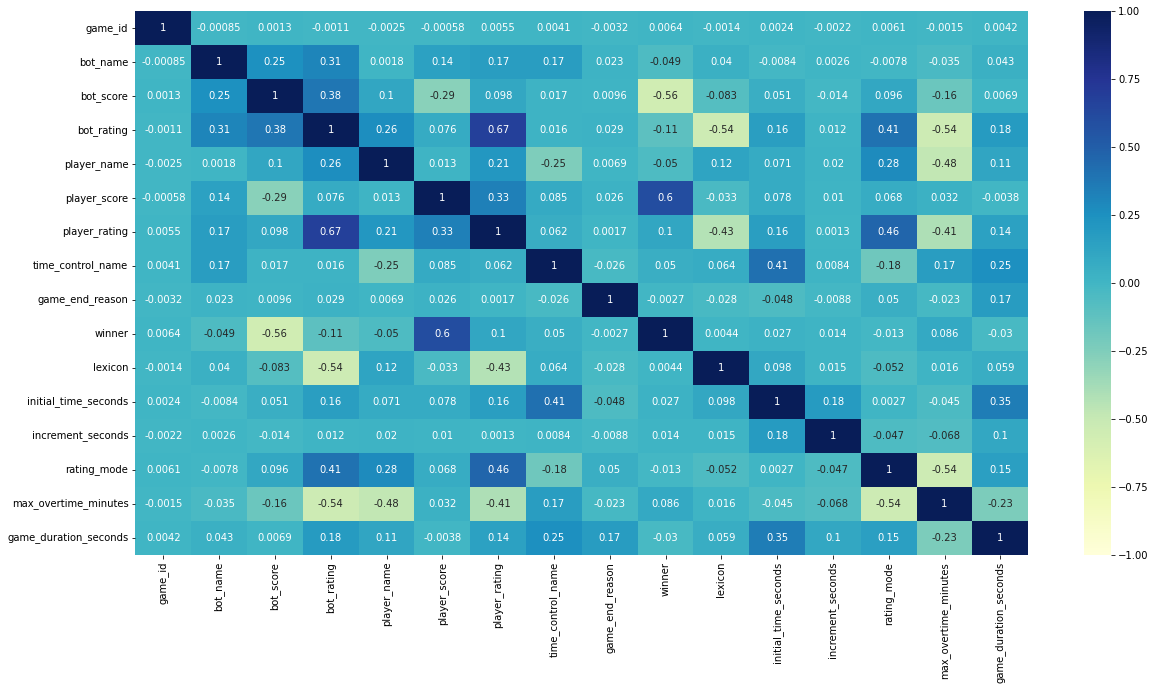

In [15]:
le_cols = ['time_control_name', 'game_end_reason', 'lexicon', 'rating_mode']
for i in le_cols:
    le_function(df2, i)
#เช็คค่า corr
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')

In [16]:
df2[:5]

,game_id,bot_name,bot_score,bot_rating,player_name,player_score,player_rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,1,335,1637,958,429,1500,BetterBot,2,2,1,2022-08-26 03:38:49,3,1200,0,0,1,674.844274
1,3,1,318,2071,709,440,1811,BetterBot,2,2,1,2022-09-04 08:04:27,0,900,0,1,5,492.268262
2,4,1,478,1936,225,119,1473,BetterBot,2,1,0,2022-09-12 02:36:19,0,3600,0,0,1,350.861141
3,5,3,427,1844,958,325,1500,STEEBot,2,2,0,2022-09-06 04:31:36,3,1200,0,0,1,642.688722
4,6,3,427,2143,213,378,2029,HivinD,2,2,0,2022-08-21 14:56:35,0,900,0,1,1,426.950541


In [17]:
df2.columns

Index(['game_id', 'bot_name', 'bot_score', 'bot_rating', 'player_name',
       'player_score', 'player_rating', 'first', 'time_control_name',
       'game_end_reason', 'winner', 'created_at', 'lexicon',
       'initial_time_seconds', 'increment_seconds', 'rating_mode',
       'max_overtime_minutes', 'game_duration_seconds'],
      dtype='object')

In [18]:
df2 = df2[[              'game_id',              'bot_name',
                   'bot_score',            'bot_rating',
                 'player_name',          'player_score',
               'player_rating',     'time_control_name',
             'game_end_reason',                'winner',
                     'lexicon',  'initial_time_seconds',
           'increment_seconds',           'rating_mode',
        'max_overtime_minutes', 'game_duration_seconds',
                   ]]

**FEATURE EXTRACTION**

In [19]:
#Scaling
scaler = StandardScaler()
scaler.fit(df2)
scaled_df = pd.DataFrame(scaler.transform(df2),columns= df2.columns )
scaled_df

,game_id,bot_name,bot_score,bot_rating,player_name,player_score,player_rating,time_control_name,game_end_reason,winner,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,-1.730067,-1.231333,-1.235350,-1.615941,1.441095,0.727804,-1.264140,0.362975,0.031272,1.321688,1.611710,-0.023616,-0.091759,-1.583359,-0.445233,0.551731
1,-1.729972,-1.231333,-1.476747,0.549536,0.678171,0.879031,0.090034,0.362975,0.031272,1.321688,-0.718267,-0.444352,-0.091759,0.631569,0.745852,-0.000567
2,-1.729924,-1.231333,0.795230,-0.124057,-0.804782,-3.534045,-1.381705,0.362975,-3.899963,-0.733284,-0.718267,3.342273,-0.091759,-1.583359,-0.445233,-0.428327
3,-1.729877,1.238191,0.071037,-0.583098,1.441095,-0.701978,-1.264140,0.362975,0.031272,-0.733284,1.611710,-0.023616,-0.091759,-1.583359,-0.445233,0.454460
4,-1.729829,1.238191,0.071037,0.908786,-0.841549,0.026661,1.039263,0.362975,0.031272,-0.733284,-0.718267,-0.444352,-0.091759,0.631569,-0.445233,-0.198155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,1.731653,-1.231333,-0.113561,-0.044224,-0.908956,-0.495759,-1.721338,0.362975,3.962507,-0.733284,-0.718267,3.342273,-0.091759,-1.583359,-0.445233,9.612131
50406,1.731796,0.003429,2.385615,1.377806,1.330793,-3.836499,-1.995656,0.362975,3.962507,-0.733284,-0.718267,3.342273,-0.091759,0.631569,-0.445233,9.589960
50407,1.731844,0.003429,-0.411758,-1.730701,-1.282758,0.191636,-1.264140,0.362975,0.031272,-0.733284,0.058392,-0.444352,-0.091759,-1.583359,2.234707,-0.775381
50408,1.731891,-1.231333,0.284035,-1.431327,-0.915084,0.164140,-1.856320,0.362975,0.031272,-0.733284,1.611710,-0.444352,-0.091759,0.631569,-0.445233,0.571472


**MACHINE LEARNING**

In [20]:
X = scaled_df.drop(columns=['player_rating'])
y = df2['player_rating']

from pandas.core.common import random_state
# เลือก Model ที่จะใช้ทำการทดลอง
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# เลือกวิธีการวัดผล
from sklearn.metrics import accuracy_score,f1_score
# เรียก Library แบ่งข้อมูล
from sklearn.model_selection import train_test_split

# data_clean = data.dropna() # Drop row ที่เป็น Na ออก
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3,random_state=0)
models = {}
result = {}

models["logistic regression"] = LogisticRegression(random_state=0)


for name,model in models.items():
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
    
# ฟังก์ชันที่ใช้ประเมินผลการทำนายโมเดล
from sklearn.metrics import mean_squared_error # กลุ่ม library สำหรับทำ machine learning
def evaluate_mse(pred, label):
  rmse = mean_squared_error(pred, label, squared=True) ** 0.5
  return rmse

print('RMSE :', evaluate_mse(pred, y_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RMSE : 165.25856260633725


**PREDICT**

In [21]:
test

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0
...,...,...,...,...
44721,72762,kyjo55555,367,NaN
44722,72768,HastyBot,524,2356.0
44723,72768,Maximilian,357,NaN
44724,72769,STEEBot,626,2110.0


In [22]:
bot = ['BetterBot', 'STEEBot', 'HastyBot']

bot_name = []
player_name = []
player_score = []
bot_score = []
player_rating = []
bot_rating = []

for i in range(0, len(test['nickname'])):
    if test['nickname'][i] in bot:
        bot_name.append(test['nickname'][i])
        bot_score.append(test['score'][i])
        bot_rating.append(test['rating'][i])
        player_name.append('')
        player_score.append(0)
        player_rating.append(0)
    else :
        bot_name.append('')
        bot_score.append(0)
        bot_rating.append(0)
        player_name.append(test['nickname'][i])
        player_score.append(test['score'][i])
        player_rating.append(test['rating'][i])
        
test['bot_name'] = bot_name
test['bot_score'] = bot_score
test['bot_rating'] = bot_rating
test['player_name'] = player_name
test['player_score'] = player_score
test['player_rating'] = player_rating

test

,game_id,nickname,score,rating,bot_name,bot_score,bot_rating,player_name,player_score,player_rating
0,2,Super,488,NaN,,0,0.0,Super,488,NaN
1,2,BetterBot,401,2000.0,BetterBot,401,2000.0,,0,0.0
2,7,STEEBot,377,2082.0,STEEBot,377,2082.0,,0,0.0
3,7,Priya1,379,NaN,,0,0.0,Priya1,379,NaN
4,11,STEEBot,334,1829.0,STEEBot,334,1829.0,,0,0.0
...,...,...,...,...,...,...,...,...,...,...
44721,72762,kyjo55555,367,NaN,,0,0.0,kyjo55555,367,NaN
44722,72768,HastyBot,524,2356.0,HastyBot,524,2356.0,,0,0.0
44723,72768,Maximilian,357,NaN,,0,0.0,Maximilian,357,NaN
44724,72769,STEEBot,626,2110.0,STEEBot,626,2110.0,,0,0.0


In [23]:
df = test.copy()
df = df.drop(['nickname', 'score', 'rating'], axis=1)
le_function(df,'bot_name')
le_function(df,'player_name')
df = df.groupby(['game_id']).sum()
df

,bot_name,bot_score,bot_rating,player_name,player_score,player_rating
game_id,,,,,,
2,1,401,2000.0,247,488,0.0
7,3,377,2082.0,196,379,0.0
11,3,334,1829.0,257,462,0.0
14,3,403,2136.0,20,359,0.0
27,2,453,2258.0,322,456,0.0
...,...,...,...,...,...,...
72760,3,386,2030.0,420,494,0.0
72761,1,469,2044.0,334,232,0.0
72762,1,299,1710.0,352,367,0.0


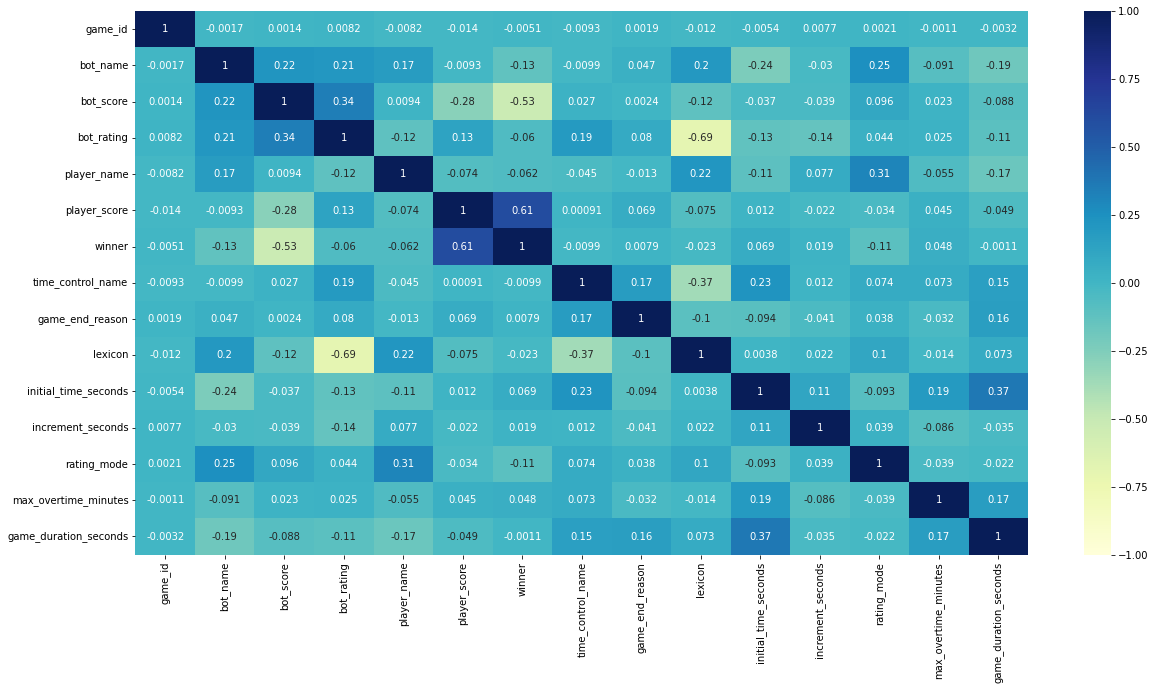

In [24]:
def file_merge(df):
  result = pd.merge(df, games,how="left", on=["game_id"])
  return result

df2 = file_merge(df)

le_cols = ['time_control_name', 'game_end_reason', 'lexicon', 'rating_mode']
for i in le_cols:
    le_function(df2, i)


df2 = df2[['game_id',  'bot_name','bot_score','bot_rating','player_name','player_score','winner','time_control_name','game_end_reason', 'lexicon','initial_time_seconds','increment_seconds',           'rating_mode',
        'max_overtime_minutes', 'game_duration_seconds',
                   ]]
#เช็คค่า corr
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22363 entries, 0 to 22362
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                22363 non-null  int64  
 1   bot_name               22363 non-null  int64  
 2   bot_score              22363 non-null  int64  
 3   bot_rating             22363 non-null  float64
 4   player_name            22363 non-null  int64  
 5   player_score           22363 non-null  int64  
 6   winner                 22363 non-null  int64  
 7   time_control_name      22363 non-null  int64  
 8   game_end_reason        22363 non-null  int64  
 9   lexicon                22363 non-null  int64  
 10  initial_time_seconds   22363 non-null  int64  
 11  increment_seconds      22363 non-null  int64  
 12  rating_mode            22363 non-null  int64  
 13  max_overtime_minutes   22363 non-null  int64  
 14  game_duration_seconds  22363 non-null  float64
dtypes:

In [26]:
#Scaling
scaler = StandardScaler()
scaler.fit(df2)
scaled_df = pd.DataFrame(scaler.transform(df2),columns= df2.columns )
scaled_df

,game_id,bot_name,bot_score,bot_rating,player_name,player_score,winner,time_control_name,game_end_reason,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,-1.736414,-1.222627,-0.364350,-0.015598,-0.064285,1.464508,1.379669,0.313688,0.030992,-0.758298,3.434599,-0.105314,0.489524,-0.211470,-0.297408
1,-1.736175,1.136950,-0.692934,0.486423,-0.486137,0.059040,1.379669,0.313688,0.030992,-0.758298,0.146631,-0.105314,0.489524,-0.211470,-0.234406
2,-1.735985,1.136950,-1.281647,-1.062496,0.018431,1.129258,1.379669,0.313688,0.030992,1.340962,0.062324,-0.105314,-2.042799,-0.211470,0.107749
3,-1.735842,1.136950,-0.336968,0.817023,-1.941940,-0.198844,-0.701233,0.313688,0.030992,-0.758298,-0.359210,-0.105314,0.489524,-0.211470,-0.506465
4,-1.735222,-0.042838,0.347582,1.563932,0.556086,1.051893,1.379669,0.313688,0.030992,-0.758298,0.062324,-0.105314,0.489524,-0.211470,-0.769519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22358,1.731615,1.136950,-0.569715,0.168068,1.366704,1.541873,1.379669,0.313688,0.030992,-0.758298,0.062324,-0.105314,0.489524,0.992324,-0.975290
22359,1.731662,-1.222627,0.566638,0.253779,0.655345,-1.836408,-0.701233,0.313688,0.030992,-0.758298,0.062324,-0.105314,0.489524,-0.211470,-0.589390
22360,1.731710,-1.222627,-1.760832,-1.791039,0.804234,-0.095691,1.379669,0.313688,0.030992,1.340962,3.434599,-0.105314,-2.042799,-0.211470,-0.232971
22361,1.731996,-0.042838,1.319644,2.163909,-0.858359,-0.224633,-0.701233,0.313688,0.030992,-0.758298,3.434599,-0.105314,0.489524,-0.211470,4.981084


In [27]:
X = scaled_df
pred2 = models["logistic regression"].predict(X)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [28]:
pred2

array([2275, 1982, 1500, ..., 1590, 2007, 2049])

In [29]:
df2 = df.reset_index('game_id')

In [30]:
summit_file = pd.DataFrame()
summit_file['game_id'] = df2['game_id']
summit_file['rating'] = pred2
summit_file

,game_id,rating
0,2,2275
1,7,1982
2,11,1500
3,14,1756
4,27,2081
...,...,...
22358,72760,1977
22359,72761,1981
22360,72762,1590
22361,72768,2007


In [31]:
summit_file.to_csv('/kaggle/working/scrabble_player.csv', index=False)